# 不同策略的回测结果

除标记为`2019年数据`的数据外都是使用的历史数据（`2014-01-01`至`2018-12-31`）对不同的开仓和平仓策略进行的测试。所有策略中使用的参数均未做优化（也许是运气好得到了不错的结论，也有可能会有更优化的参数。但是会陷入过度优化陷阱）

从使用历史数据测试结果来看，所有策略的R值均在低于2。

使用`2019年数据（2019-01-01~2019-12-31）`的测试结果中的R值进一步降低。最终价值仅增长`20%`。

**策略说明：**

- 买入：布林带开口大小(极限宽指标)>0.2，并且收盘价在中线以上。
- 买入（加仓）：当天价格在波幅通道之上，并且当天收盘价大于最后一次购买价格+1倍购买日ATR
- 卖出：收盘价下穿中线。
- 卖出：持仓达到6日（以历史数据的亏损交易平均持仓时间为值），并且当日价格小于或等于现有持仓的当时买入价

|                                                             |   盈亏总额 |   最终价值 |   交易次数 |   盈利次数 |   亏损次数 |   盈利比率 |   每笔交易平均盈亏额 |   盈利交易平均盈利额 |   亏损交易平均亏损额 |    R |   最大回撤 |   买入平均花费 |
|:------------------------------------------------------------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|---------------------:|---------------------:|---------------------:|-----:|-----------:|---------------:|
| 回测-自制策略-布林带开口                                    |   22159.5  |    27050.4 |        118 |         54 |         64 |   0.457627 |             144.448  |              410.361 |             -79.9153 | 1.81 |  -0.233849 |        2380.28 |
| 回测-自制策略-布林带开口-增加最多持仓天数的卖出策略         |   22159.5  |    27027.6 |        118 |         54 |         64 |   0.457627 |             141.088  |              410.361 |             -86.1102 | 1.64 |  -0.229233 |        2383.45 |
| 回测-自制策略-布林带开口-增加止损(1倍ATR）止盈（10倍ATR）   |   22159.5  |    27050.4 |        118 |         54 |         64 |   0.457627 |             144.448  |              410.361 |             -79.9153 | 1.81 |  -0.233849 |        2380.28 |
| 回测-自制策略-布林带开口-增加有持仓情况下2倍ATR时的加仓策略 |   26542.8  |    30941.9 |        137 |         65 |         72 |   0.474453 |             152.811  |              408.35  |             -77.8843 | 1.96 |  -0.229743 |        2314.4  |
| 回测-自制策略-布林带开口(2019年数据)                        |    2116.27 |    11362.9 |         25 |         17 |          8 |   0.68     |              54.4967 |              124.486 |             -94.231  | 0.58 |  -0.250545 |        1510.81 |
| 回测-自制策略-布林带开口+凯利公式仓位控制(2019年数据)       |    2718.83 |    11976.3 |         11 |          6 |          5 |   0.545455 |             179.602  |              453.138 |            -148.642  | 1.21 |  -0.321976 |        4084.19 |

**值得注意的是所有测试均只采用了300378一只股票进行测试。**

**蒙特卡洛模拟**

采用完整数据（2014-01-01\~2020-05-20），从中随机选出500\~1500天的连续数据，分别进行3轮测试（100次，1000次，~~10000次~~（未因为100和1000次的测试结果均不佳，并且由于10000次的测试耗时过多，所以跳过了10000次的测试））。使用凯利公式对仓位进行管理。

|   测试轮数 |   count |    mean |      std |   min |   25% |   50% |    75% |   max |
|-----------:|--------:|--------:|---------:|------:|------:|------:|-------:|------:|
|        100 |      88 | 1.56455 | 0.705114 |  0.1  |  0.97 | 1.735 | 2.0275 |  2.72 |
|       1000 |      89 | 1.43618 | 0.759784 |  0.09 |  0.69 | 1.56  | 1.97   |  2.72 |

In [2]:
import gquant
import abupy
import QUANTAXIS as QA
import gquant.jupyter_helper
gquant.jupyter_helper.init()
import logging
logging.disable(logging.DEBUG)

# 原始数据

In [3]:
# 原始未复权数据
ori_data_df = gquant.pd.read_csv('300378_daily.csv', 
                                 encoding='utf-8', 
                                 parse_dates=[0], 
                                 dtype={'code': str}).set_index(['date', 'code'])
ori_data = QA.QAData.QA_DataStruct_Stock_day(ori_data_df)
# 前复权数据
ori_data_df_qfq = ori_data.to_qfq().data

'DataFrame' object has no attribute 'date'
use old model qfq


# 数据初始化

In [149]:
class LocalDataAPI(abupy.MarketBu.ABuDataBase.StockBaseMarket,
                   abupy.MarketBu.ABuDataBase.SupportMixin):
    def _support_market(self):
        """声明数据源支持A股"""
        return [abupy.EMarketTargetType.E_MARKET_TARGET_CN]

    def kline(self, n_folds=2, start=None, end=None):
        df = ori_data_df_qfq.copy()
        df['pre_close'] = df['close'].shift()
        df['date'] = df.index.get_level_values(0)
        df['date'] = df['date'].dt.strftime('%Y%m%d').apply(
            lambda x: abupy.ABuDateUtil.date_str_to_int(x))
        df.index = df.index.droplevel(1)
        df.index.name = 'dt'
        df['date_week'] = df.index.dayofweek
        if start and end:
            return df[start:end]
        elif start:
            return df[start:]
        elif end:
            return df[:end]
        return df

    def minute(self, n_fold=5, *args, **kwargs):
        """分钟k线接口"""
        raise NotImplementedError('QAApi minute NotImplementedError!')

In [150]:
abupy.env.g_market_target = abupy.env.EMarketTargetType.E_MARKET_TARGET_CN
# 所有任务数据强制网络更新
abupy.env.g_data_fetch_mode = abupy.env.EMarketDataFetchMode.E_DATA_FETCH_FORCE_NET
# 使用QUATAXIS本地数据作为数据源
abupy.env.g_private_data_source = LocalDataAPI

In [5]:
# symbol = abupy.ABuMarket.code_to_symbol('sz300378')
# df = LocalDataAPI(symbol).kline()
# df

采用20日，上下2倍标准差的标准计算方式。计算简单移动平均的布林带。

In [21]:
from abupy.IndicatorBu.ABuNDAtr import calc_atr
from QUANTAXIS.QAIndicator.talib_series import SMA
from QUANTAXIS.QAIndicator.talib_series import BBANDS

class KLManager(abupy.AbuKLManager):
    def _fetch_pick_time_kl_pd(self, target_symbol):
        data = abupy.MarketBu.ABuSymbolPd.make_kl_df(target_symbol,start=self.benchmark.start,end=self.benchmark.end)
        if not data.empty:
            high = data['high']
            low = data['low']
            pre_close = data['pre_close']
            data['ma']=SMA(data['close'],20)
            data['atr']=calc_atr(high, low, pre_close, 20)
            data['up']=data['ma']+data['atr']
            data['low']=data['ma']-data['atr']
            data['atr14'] = calc_atr(high, low, pre_close, 14)
            data['atr21'] = calc_atr(high, low, pre_close, 21)
            data['bb_up'],data['bb_mid'],data['bb_low']=BBANDS(data['close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
            data['WIDTH']=(data['bb_up']-data['bb_low'])/data['bb_mid']#极限宽指标
            result = data[self.benchmark.start:self.benchmark.end]
            result.name = data.name
        else:
            return data
#         logging.info(result)
        return result

## 初始化数据读取示例

In [10]:
# 沪深300指数
benchmark=gquant.abupy.TradeBu.ABuBenchmark.AbuBenchmark(benchmark='000300', start='2014-01-01', end='2018-12-31')
# 资金管理。使用默认的手续费计算方法
capital=gquant.abupy.TradeBu.ABuCapital.AbuCapital(10000,benchmark,)

In [12]:
# abupy.MarketBu.ABuSymbolPd.make_kl_df('300378')

# 想法验证

初步想法是当一段时间的布林带开口突然打开，并且收盘价位于简单移动均线上方时，是否是好的买入时机。

采用[极限宽指标](https://wiki.mbalib.com/wiki/%E6%9E%81%E9%99%90%E5%AE%BD%E6%8C%87%E6%A0%87)对布林带开口大小进行衡量。

In [22]:
simple_data=KLManager(benchmark,capital).get_pick_time_kl_pd('300378')

In [69]:
# simple_data

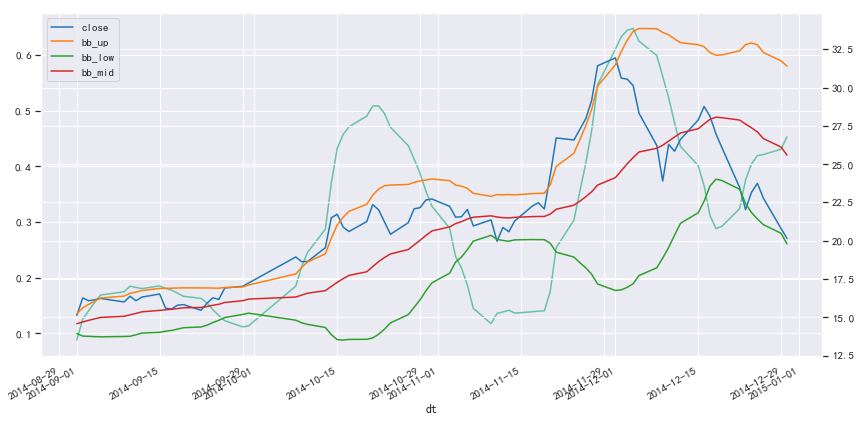

In [63]:
colors=gquant.sns.mpl_palette("Set2", 2)
ax1=simple_data.loc['2014-09-01':'2014-12-30'].WIDTH.plot(label='极限宽',color=colors[0])
ax2 = ax1.twinx()
simple_data.loc['2014-09-01':'2014-12-30',['close','bb_up','bb_low','bb_mid']].plot(ax=ax2)
gquant.plt.legend()

# 简单测试

**问题**： 所有简单测试都并不准确，仅做示例参考。因为：

1. 以当日收盘价作为判断依据的同时，以当日作为建仓或清仓标准是不合理的。
2. 没有考虑交易手续费

In [45]:
def simple_test(data,**kwargs):
    """
    
    Args:
        cols1 (list): 第一个y轴的标签集合。默认为`['close']`。
        cols2 (list): 第二个y轴的标签集合。默认为`[]`。第二个轴会显示为虚线。
    """
    fig, ax1 = gquant.plt.subplots()
    # 绘制完整布林带买卖盈亏示例
    data[kwargs.pop('cols1',['close'])].plot(figsize=(50,10),ax=ax1)
    if 'buy' in data:
        ax1.vlines(data[data['buy'] == 1].index,0,data[data['buy'] == 1]['close'].max(),colors='r', linestyle=':')
    if 'sell' in data:
        ax1.vlines(data[data['sell'] == 1].index,0,data[data['buy'] == 1]['close'].max(), colors='g',linestyle=':')
    simple_profit=[]#盈亏示例
    record=[]#成交明细
    if 'buy' in data and 'sell' in data:
        last_buy=[]
        for index,row in data.iterrows():
            if row['buy']==1:
                last_buy.append(index)
                continue
            if row['sell']==1:
                while last_buy:
                    b=last_buy.pop(0)
                    buy_close=data['close'][b]
                    sell_close=data['close'][index]
                    record.append(gquant.pd.DataFrame(
                    {
                        'bd':[b],#买入日期
                        'bp':[buy_close],#买入价格
                        'sd':[index],#卖出日期
                        'sp':[sell_close],#卖出价格
                        'h':[len(data['close'][b:index])],#持仓天数
                        'sc':[100]#模拟买入100股
                    }))
                    pf=(sell_close-buy_close)/buy_close#交易盈亏率
                    data.loc[b:index,'close'].plot.area(ax=ax1,color='g' if sell_close<=buy_close else 'r', alpha=0.5)
                    ax1.annotate('{:.2f}'.format(pf),(b,buy_close), fontsize=16)
                    simple_profit.append(pf)
        record=gquant.pd.concat(record)
        record['profit']=record.apply(lambda x:(x.sp-x.bp)*x.sc,axis=1)
    cols2=kwargs.pop('cols2',[])
    if cols2:
        ax2 = ax1.twinx()
        data[cols2].plot(ax=ax2,ls='--')
        ax2.tick_params(axis='y')
    fig.tight_layout()
    gquant.plt.show()
    
    if simple_profit:
        # 绘制单次盈亏比率柱状图
        simple_profit=gquant.pd.Series(simple_profit)
        simple_profit.round(2).sort_index().plot(kind='bar',figsize=(20,3),title='单次盈亏比率')
        gquant.plt.show()
    
        # 绘制盈亏占比饼图
        gquant.pd.Series(gquant.np.sign(simple_profit)).value_counts().plot(kind='pie', autopct='%1.1f%%',figsize=(5,3),title='盈亏次数占比')
        gquant.plt.show()
        
        s= gquant.pd.Series(
            {
                '盈利交易平均盈利比率':simple_profit[simple_profit > 0].mean(),
                '最大盈利比率':simple_profit.max(),
                '亏损交易平均亏损比率':simple_profit[simple_profit <= 0].mean(),
                '最大亏损比率':simple_profit.min(),
                '平均盈亏比率':simple_profit.mean(),
                '交易次数':simple_profit.count(),
                '总天数':len(data),
                '平均持仓天数':record['h'].mean(),
                'R(平均利润/平均损失)':abs(record['profit'].mean()) / abs(record[record['profit']<=0]['profit'].mean())
            })
        return s
    return gquant.pd.Series()

## 布林带

- 买入：布林带开口大小(极限宽指标)>0.2，并且收盘价在中线以上。
- 卖出：收盘价下穿中线。

测试了2014~2018年之间的数据。

|                              |   盈利交易平均盈利比率 |   最大盈利比率 |   亏损交易平均亏损比率 |   最大亏损比率 |   平均盈亏比率 |   交易次数 |   总天数 |   平均持仓天数 |   R(平均利润/平均损失) |
|:-----------------------------|-----------------------:|---------------:|-----------------------:|---------------:|---------------:|-----------:|---------:|---------------:|-----------------------:|
| 简单测试-通道策略-布林带开口 |                   0.13 |           0.66 |                  -0.07 |          -0.25 |          -0.01 |        242 |     1198 |          11.08 |                   0.03 |

问题：[简单测试的问题说明](#%E7%AE%80%E5%8D%95%E6%B5%8B%E8%AF%95)

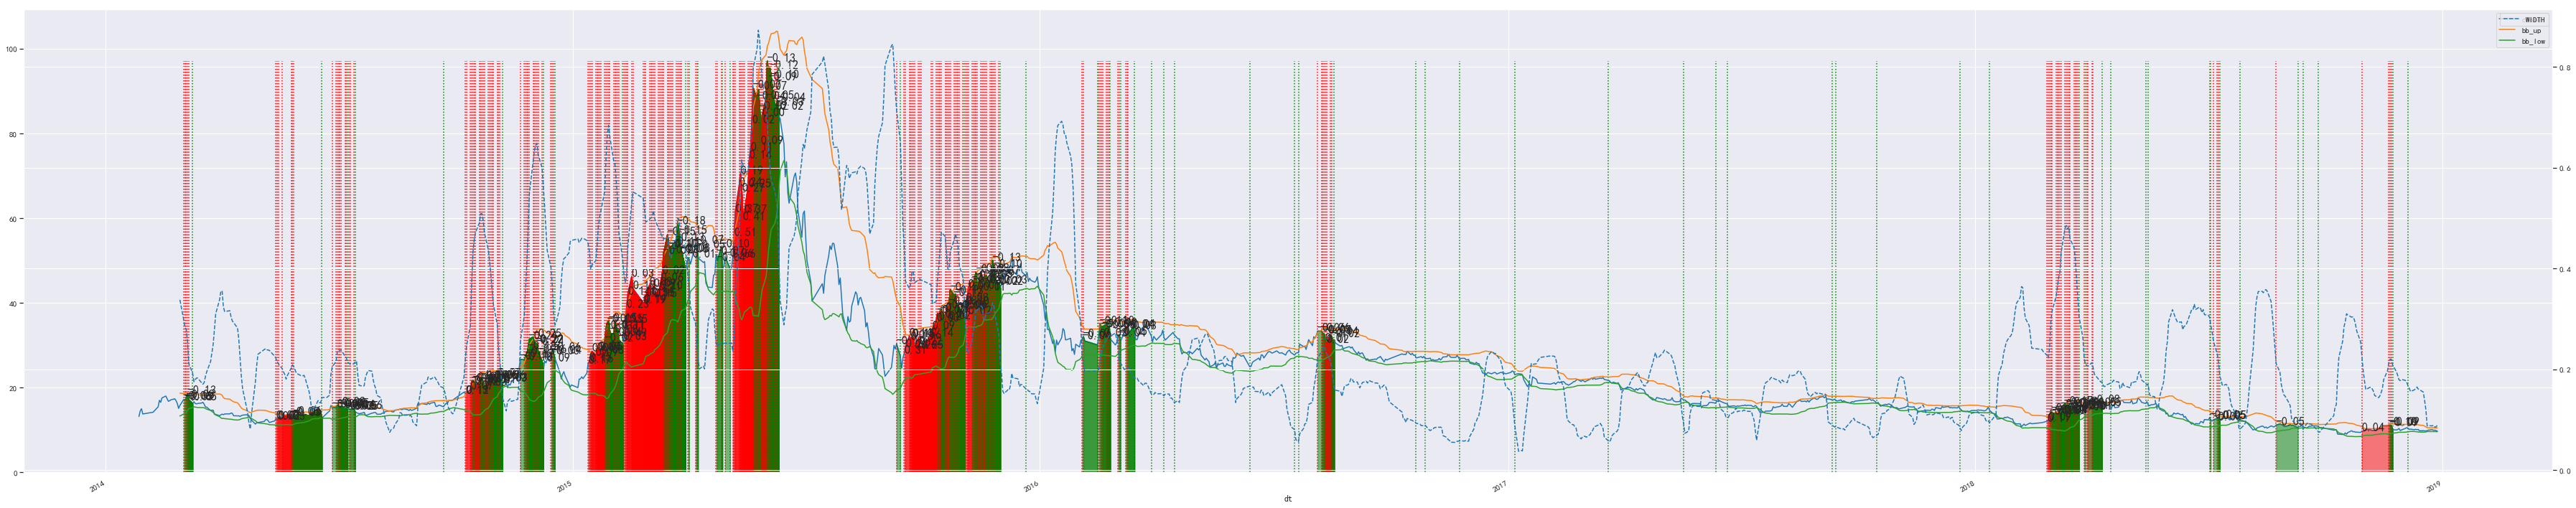

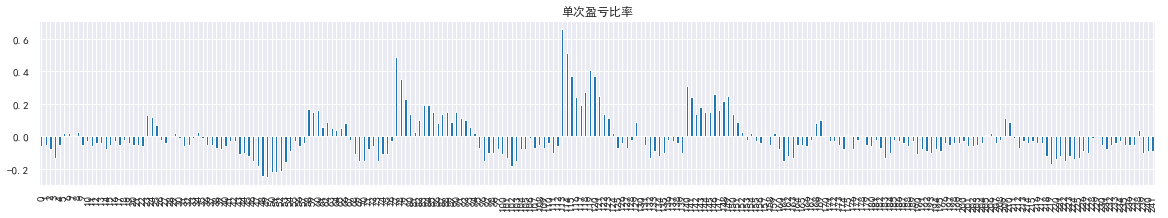

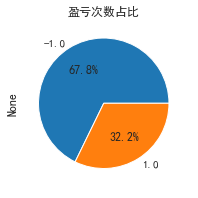

In [80]:
simple_data=KLManager(benchmark,capital).get_pick_time_kl_pd('300378')
simple_data.loc[(simple_data['WIDTH'] > 0.2)&(simple_data['close']>simple_data['bb_mid']),'buy']=1
simple_data['sell']=QA.QAIndicator.CROSS(simple_data['bb_mid'],simple_data['close'])

st1=simple_test(simple_data.loc['2014-01-01':'2018-12-31'],cols1=['close','bb_up','bb_low'],cols2=['WIDTH'])

In [81]:
st1.name="简单测试-通道策略-布林带开口"
print(st1.to_frame().T.round(2).to_markdown())

|                              |   盈利交易平均盈利比率 |   最大盈利比率 |   亏损交易平均亏损比率 |   最大亏损比率 |   平均盈亏比率 |   交易次数 |   总天数 |   平均持仓天数 |   R(平均利润/平均损失) |
|:-----------------------------|-----------------------:|---------------:|-----------------------:|---------------:|---------------:|-----------:|---------:|---------------:|-----------------------:|
| 简单测试-通道策略-布林带开口 |                   0.13 |           0.66 |                  -0.07 |          -0.25 |          -0.01 |        242 |     1198 |          11.08 |                   0.03 |


# 训练回测

## 仓位控制方法

In [82]:
class Position1(abupy.AbuPositionBase):
    """1手"""
    def _init_self(self, **kwargs):
        """子类仓位管理针对可扩展参数的初始化"""
        pass

    def fit_position(self, factor_object):
        return 100

## 回测方法

In [83]:
def backtest(buy_factors,sell_factors,init_cash=10000,**kwargs):
    start = kwargs.pop('start','2014-01-01')
    end = kwargs.pop('end','2018-12-31')

    benchmark = abupy.AbuBenchmark('000300', start, end)
    capital = abupy.AbuCapital(init_cash, benchmark)
    klmanager=kwargs.pop('klmanager',KLManager)
    orders_pd, action_pd, _ = abupy.ABuPickTimeExecute.do_symbols_with_same_factors(
        ['300378'],
        benchmark,
        buy_factors,
        sell_factors,
        capital,
        kl_pd_manager=klmanager(benchmark, capital),
        show=False)
    m = gquant.Metrics(orders_pd, action_pd, capital, benchmark)
    m.fit_metrics()
    if hasattr(m, 'act_sell') and not m.act_sell.empty:
        m.act_sell['profit_init']=m.act_sell['profit'] / m.capital.read_cash
        m.act_sell['profit_init_hunder'] = m.act_sell['profit_init'] * 100
        return m
    return None

## 回测结果绘图

In [84]:
def plot_cum_returns(metrics):
    metrics.benchmark_cum_returns.plot()
    metrics.algorithm_cum_returns.plot()
    gquant.plt.legend(['基准收益', '策略收益'], loc='best')
    gquant.plt.title('收益对比')
    gquant.plt.show()

def plot_win_loss_pie(metrics):
    gquant.plt.pie(x=[len(metrics.ret), len(metrics.los)],
                   labels=['盈利', '亏损'],
                   colors=['#d62728', '#2ca02c'],
                   autopct='%1.2f%%')
    gquant.plt.title('盈亏次数比')
    gquant.plt.show()
    
def plot_win_loss_bar(metrics,v='profit_cg_hunder'):
    import matplotlib.ticker
    vc=gquant.np.round(metrics.act_sell[v],0).value_counts().sort_index().to_frame()
    ax=vc.plot(kind='bar',title='盈亏百分比次数')
#     gquant.plt.axvline(x=gquant.np.where(vc.index.to_numpy()==0)[0], color='#d68a27')
#     ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
    gquant.plt.show()
    
def plot_capital_blance(metrics):
    metrics.capital.capital_pd.capital_blance.plot(title='账户价值曲线')
    metrics.capital.capital_pd.cash_blance .plot(title='账户现金曲线')
    gquant.plt.xticks(rotation=70)
    gquant.plt.show()

## 布林带开口

- 买入：布林带开口大小(极限宽指标)>0.2，并且收盘价在中线以上。
- 卖出：收盘价下穿中线。

- 仓位控制：每次买入100股。（[Position1](#%E4%BB%93%E4%BD%8D%E6%8E%A7%E5%88%B6%E6%96%B9%E6%B3%95)）
- 总资金：10000元
- 回测时间段：2014-01-01 ~ 2018-12-31

|                          |   盈亏总额 |   最终价值 |   交易次数 |   盈利次数 |   亏损次数 |   盈利比率 |   每笔交易平均盈亏额 |   盈利交易平均盈利额 |   亏损交易平均亏损额 |    R |   最大回撤 |   买入平均花费 |
|:-------------------------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|---------------------:|---------------------:|---------------------:|-----:|-----------:|---------------:|
| 回测-自制策略-布林带开口 |    22159.5 |    27050.4 |        118 |         54 |         64 |   0.457627 |              144.448 |              410.361 |             -79.9153 | 1.81 |  -0.233849 |        2380.28 |

### 数据预处理

In [16]:
# class KLManager1(abupy.AbuKLManager):
#     def _fetch_pick_time_kl_pd(self, target_symbol):
#         data = abupy.MarketBu.ABuSymbolPd.make_kl_df(target_symbol)
#         if not data.empty:
#             high = data['high']
#             low = data['low']
#             pre_close = data['pre_close']
#             data['atr14'] = calc_atr(high, low, pre_close, 14)
#             data['atr21'] = calc_atr(high, low, pre_close, 21)
#             for ma in [10,20]:
#                 data['ma{}'.format(ma)] = SMA(data.close,timeperiod=ma)
#             # 短期均线(10日)上穿长期均线(20日)
#             data['buy']=QA.QAIndicator.CROSS(data['ma10'],data['ma20'])
#             # 长期均线(20日)上穿短期均线(10日)（卖出）
#             data['sell']=QA.QAIndicator.CROSS(data['ma20'],data['ma10'])
#         result = data[self.benchmark.start:self.benchmark.end]
#         result.name = data.name
#         return result

### 买卖策略

In [87]:
class BuyStrategy1(gquant.abupy.AbuFactorBuyTD, gquant.abupy.BuyCallMixin):
    def _init_self(self, **kwargs):
        self.factor_name = self.__class__.__name__

    def fit_day(self, today):
        if (today['WIDTH'] > 0.2) & (today['close']>today['bb_mid']):
            return self.buy_tomorrow()
        return None
    
class SellStrategy1(gquant.abupy.AbuFactorSellBase):
    def _init_self(self, **kwargs):
        self.factor_name = self.__class__.__name__

    def support_direction(self):
        """支持的方向，只支持正向"""
        return [abupy.ESupportDirection.DIRECTION_CAll.value]

    def fit_day(self, today, orders):
        if today['bb_mid']>today['close']:
            for order in orders:
                self.sell_tomorrow(order)

In [88]:
# 买入因子
buy_factors = [
    {
        'class': BuyStrategy1,
        # 仓位管理
        'position': {
            'class': Position1
        }
    },
]

# 卖出因子
sell_factors = [{
    'class': SellStrategy1,
}]

bt1 = backtest(buy_factors,sell_factors)

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

### 结果

In [89]:
print(bt1.profit_series(name='回测-自制策略-布林带开口').to_frame().T.to_markdown())

|                          |   盈亏总额 |   最终价值 |   交易次数 |   盈利次数 |   亏损次数 |   盈利比率 |   每笔交易平均盈亏额 |   盈利交易平均盈利额 |   亏损交易平均亏损额 |    R |   最大回撤 |   买入平均花费 |
|:-------------------------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|---------------------:|---------------------:|---------------------:|-----:|-----------:|---------------:|
| 回测-自制策略-布林带开口 |    22159.5 |    27050.4 |        118 |         54 |         64 |   0.457627 |              144.448 |              410.361 |             -79.9153 | 1.81 |  -0.233849 |        2380.28 |


### 结果绘图

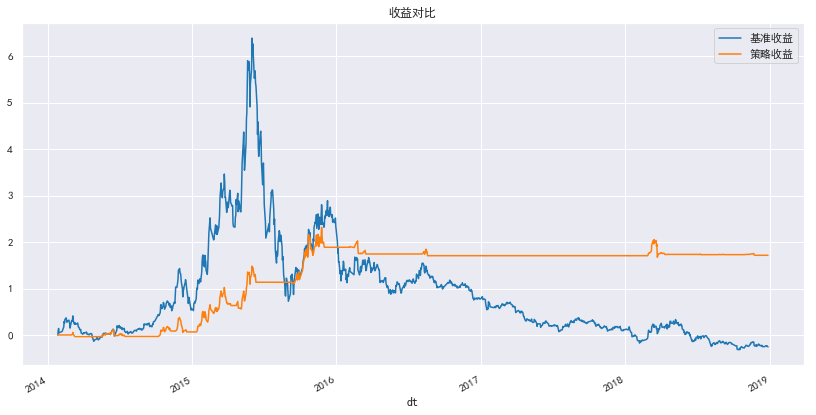

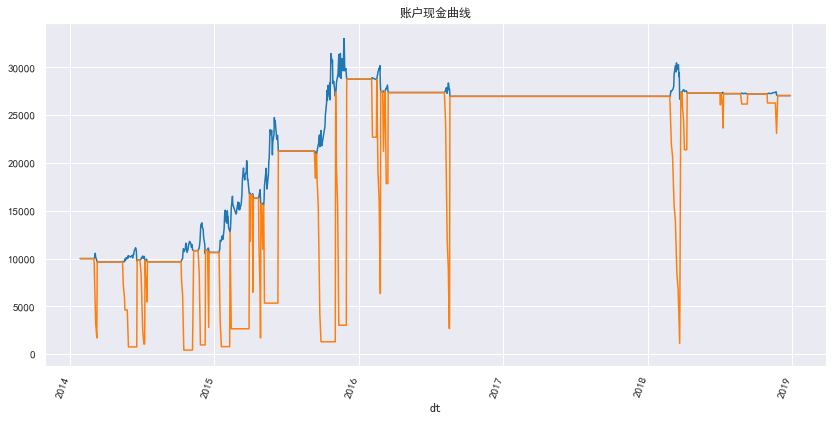

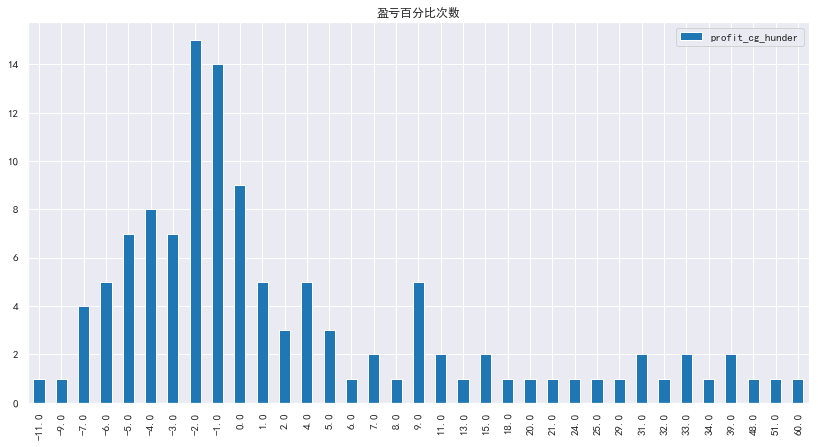

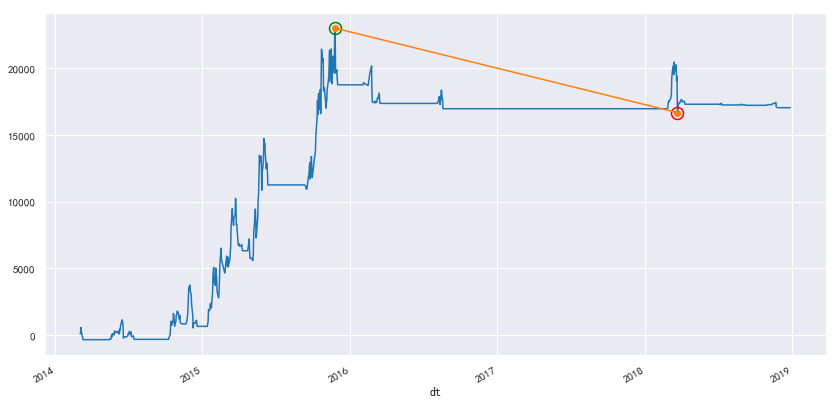

最大回撤: 0.192081
最大回测启始时间:2015-11-25, 结束时间2018-03-23, 共回测6342.827000
策略持股天数平均数: 14.693
策略持股天数中位数: 12.000


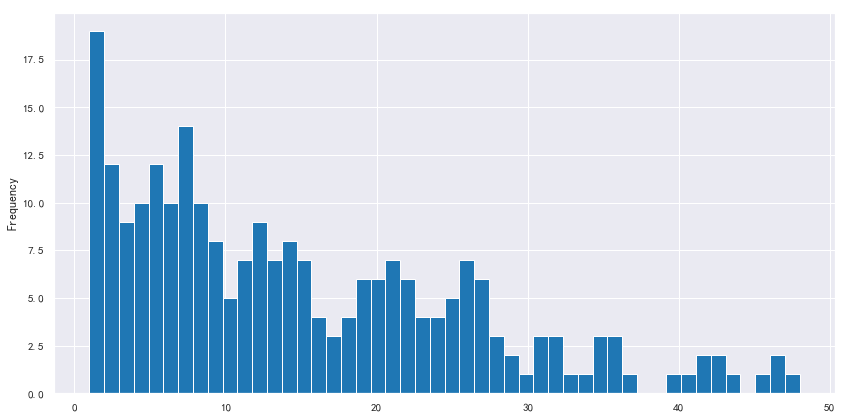

因子平均生效间隔:14.743589743589743


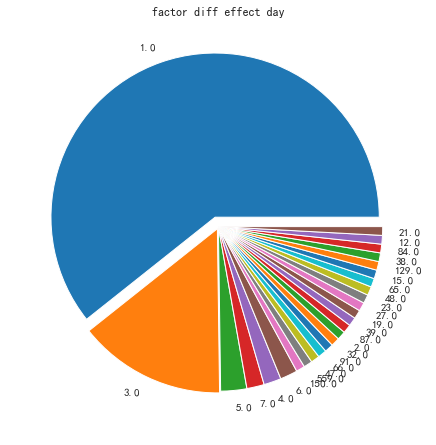

开仓花费情况: 
count:118
max:5255.176280130295
min:946.8386447290123
mean:2380.2805724632713
std:1140.8262454694902
skewness:0.7797211375448189
kurtosis:-0.3097571252488409


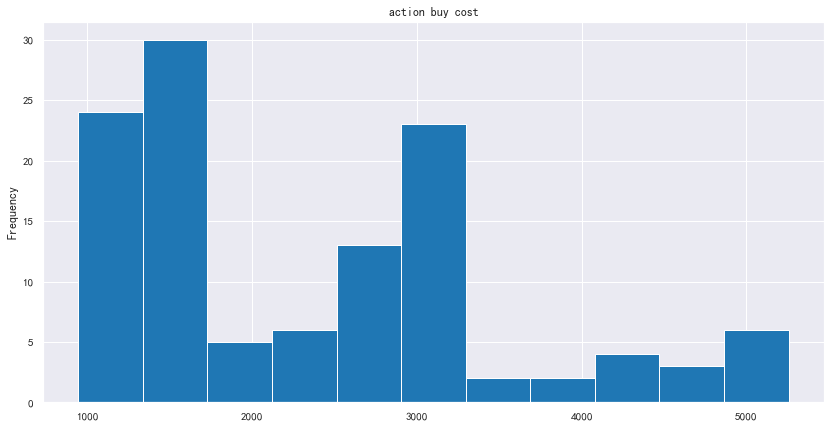

In [90]:
plot_cum_returns(bt1)
plot_capital_blance(bt1)
plot_win_loss_bar(bt1)
bt1.plot_max_draw_down()
bt1.plot_keep_days()
bt1.plot_effect_mean_day()
bt1.plot_action_buy_cost()

### 获利期望

买入后卖出的交易数量:58
买入后尚未卖出的交易数量:0
胜率:58.6207%
平均获利期望:18.7781%
平均亏损期望:-3.9161%
盈亏比:7.6317
策略收益: 147.4255%
基准收益: -25.7539%
策略年化收益: 31.0110%
基准年化收益: -5.4174%
策略买入成交比例:89.6552%
策略资金利用率比例:17.5703%
策略共执行1198个交易日


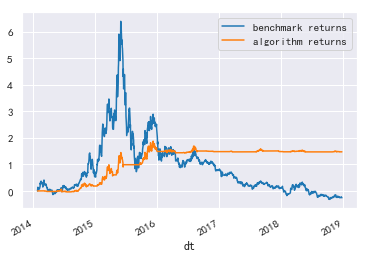

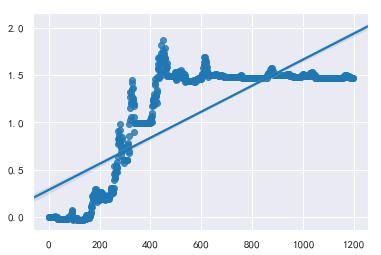

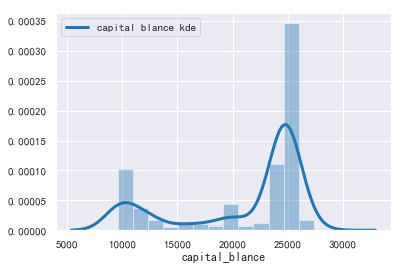

In [21]:
bt1.plot_returns_cmp()

通过盈利/亏损交易的持仓时间分析来看，不应该使用持仓N天之后就卖出的止损策略（啪啪打脸）

In [91]:
import logging
logging.info('盈利交易持仓时间')
logging.info(bt1.order_has_ret[bt1.order_has_ret.profit>0].keep_days.describe())
logging.info('亏损交易持仓时间')
logging.info(bt1.order_has_ret[bt1.order_has_ret.profit<=0].keep_days.describe())

盈利交易持仓时间
count    140.0000
mean      20.8214
std       11.2501
min        1.0000
25%       13.0000
50%       21.0000
75%       27.0000
max       48.0000
Name: keep_days, dtype: float64
亏损交易持仓时间
count    101.0000
mean       6.1980
std        3.8549
min        1.0000
25%        3.0000
50%        6.0000
75%        9.0000
max       15.0000
Name: keep_days, dtype: float64


## 增加最多持仓天数的卖出策略

### 卖出策略

In [101]:
class SellStrategy2(abupy.AbuFactorSellBase):
    """n日卖出策略。当N日后股价小于等于买入价时卖出。"""

    def _init_self(self, **kwargs):
        """kwargs中可以包含: 参数sell_n：代表买入后持有的天数，默认6天"""
        self.sell_n = kwargs.pop('sell_n', 6)
        self.sell_type_extra = '{}:sell_n={}'.format(self.__class__.__name__, self.sell_n)

    def support_direction(self):
        """因子支持两个方向"""
        return [abupy.ESupportDirection.DIRECTION_CAll.value]


    def fit_day(self, today, orders):
        for order in orders:
            # 将单子的持有天数进行增加
            order.keep_days += 1
            if order.keep_days >= self.sell_n and order.buy_price>=today.close:
                self.sell_tomorrow(order)

In [102]:
buy_factors = [
    {
        'class': BuyStrategy1,
        # 仓位管理
        'position': {
            'class': Position1
        }
    }
]

# 卖出因子
sell_factors = [{
    'class': SellStrategy1,
},
    {
    'class': SellStrategy2,
}]
bt2 = backtest(buy_factors, sell_factors)

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

### 结果

以6日（亏损交易的平均持仓天数）为参数值。增加了此止损策略后，亏损交易平均亏损额增加的同时赢利交易平均盈利额并未增加。导致R值下降。

In [103]:
print(bt2.profit_series(name='回测-自制策略-布林带开口-增加最多持仓天数的卖出策略').to_frame().T.to_markdown())

|                                                     |   盈亏总额 |   最终价值 |   交易次数 |   盈利次数 |   亏损次数 |   盈利比率 |   每笔交易平均盈亏额 |   盈利交易平均盈利额 |   亏损交易平均亏损额 |    R |   最大回撤 |   买入平均花费 |
|:----------------------------------------------------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|---------------------:|---------------------:|---------------------:|-----:|-----------:|---------------:|
| 回测-自制策略-布林带开口-增加最多持仓天数的卖出策略 |    22159.5 |    27027.6 |        118 |         54 |         64 |   0.457627 |              141.088 |              410.361 |             -86.1102 | 1.64 |  -0.229233 |        2383.45 |


In [104]:
gquant.pd.concat([bt1.profit_series(name='回测-自制策略-布林带开口'),
                  bt2.profit_series(name='回测-自制策略-布林带开口-增加最多持仓天数的卖出策略')]
                ,axis=1).T

,盈亏总额,最终价值,交易次数,盈利次数,亏损次数,盈利比率,每笔交易平均盈亏额,盈利交易平均盈利额,亏损交易平均亏损额,R,最大回撤,买入平均花费
回测-自制策略-布林带开口,22159.4802,27050.430,118.0,54.0,64.0,0.4576,144.4483,410.3607,-79.9153,1.81,-0.2338,2380.2806
回测-自制策略-布林带开口-增加最多持仓天数的卖出策略,22159.4802,27027.636,118.0,54.0,64.0,0.4576,141.0884,410.3607,-86.1102,1.64,-0.2292,2383.4474


## 增加止损(1倍ATR）止盈（10倍ATR）

In [105]:
buy_factors = [
    {
        'class': BuyStrategy1,
        # 仓位管理
        'position': {
            'class': Position1
        }
    }
]

# 卖出因子
sell_factors = [{
    'class': SellStrategy1,
},
    {
    'class': abupy.AbuFactorAtrNStop,
    'stop_loss_n': 1,
    'stop_win_n': 10
}]
bt3 = backtest(buy_factors, sell_factors)

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

### 结果

~~*原本就是以1倍的20日ATR作为上轨买入，跌破中轨时卖出。所以实际意义上就是以ATR作为止损线。实际测试中也是结果数据与不增加此方法的止盈止损一致。*~~

In [106]:
print(bt3.profit_series(name='回测-自制策略-布林带开口-增加止损(1倍ATR）止盈（10倍ATR）').to_frame().T.to_markdown())

|                                                           |   盈亏总额 |   最终价值 |   交易次数 |   盈利次数 |   亏损次数 |   盈利比率 |   每笔交易平均盈亏额 |   盈利交易平均盈利额 |   亏损交易平均亏损额 |    R |   最大回撤 |   买入平均花费 |
|:----------------------------------------------------------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|---------------------:|---------------------:|---------------------:|-----:|-----------:|---------------:|
| 回测-自制策略-布林带开口-增加止损(1倍ATR）止盈（10倍ATR） |    22159.5 |    27050.4 |        118 |         54 |         64 |   0.457627 |              144.448 |              410.361 |             -79.9153 | 1.81 |  -0.233849 |        2380.28 |


In [107]:
gquant.pd.concat([bt1.profit_series(name='回测-自制策略-布林带开口'),
                  bt2.profit_series(name='回测-自制策略-布林带开口-增加最多持仓天数的卖出策略'),
                  bt3.profit_series(name='回测-自制策略-布林带开口-增加止损(1倍ATR）止盈（10倍ATR）')]
                ,axis=1).T

,盈亏总额,最终价值,交易次数,盈利次数,亏损次数,盈利比率,每笔交易平均盈亏额,盈利交易平均盈利额,亏损交易平均亏损额,R,最大回撤,买入平均花费
回测-自制策略-布林带开口,22159.4802,27050.430,118.0,54.0,64.0,0.4576,144.4483,410.3607,-79.9153,1.81,-0.2338,2380.2806
回测-自制策略-布林带开口-增加最多持仓天数的卖出策略,22159.4802,27027.636,118.0,54.0,64.0,0.4576,141.0884,410.3607,-86.1102,1.64,-0.2292,2383.4474
回测-自制策略-布林带开口-增加止损(1倍ATR）止盈（10倍ATR）,22159.4802,27050.430,118.0,54.0,64.0,0.4576,144.4483,410.3607,-79.9153,1.81,-0.2338,2380.2806


~~## (当前收盘价-当前均价)与当前ATR之间的倍数关系~~

In [110]:
# a=(simple_data['close']-simple_data['ma'])/simple_data['atr']
# gquant.sns.distplot(a.dropna())
# gquant.plt.axvline(x=a.mean(), ymin=0, ymax=1,label='mean:{:.2f}'.format(a.mean()))
# gquant.plt.axvline(x=a.median(), ymin=0, ymax=1,label='median:{:.2f}'.format(a.median()))
# gquant.plt.legend()
# logging.info(a.describe())

~~## 增加超过三倍ATR时的止盈策略~~

~~根据上图，因为最大的倍数为`3.7739`，所以尝试增加倍数超过3倍ATR时止盈的策略。~~

~~效果并不好，违反了让利润奔跑的原则。~~

~~### 止盈策略~~

In [111]:
# class SellStrategy3(abupy.AbuFactorSellBase):
#     """n日卖出策略。当N日后股价小于等于买入价时卖出。"""

#     def _init_self(self, **kwargs):
#         """kwargs中可以包含: 参数sell_n：代表买入后持有的天数，默认20天"""
#         self.sell_n = kwargs.pop('sell_n', 20)
#         self.sell_type_extra = '{}:sell_n={}'.format(self.__class__.__name__, self.sell_n)

#     def support_direction(self):
#         """因子支持两个方向"""
#         return [abupy.ESupportDirection.DIRECTION_CAll.value]


#     def fit_day(self, today, orders):
#         for order in orders:
#             if (today['ma']+3*today['atr'])<today['close']:
#                 self.sell_tomorrow(order)

In [112]:
# buy_factors = [
#     {
#         'class': BuyStrategy1,
#         # 仓位管理
#         'position': {
#             'class': Position1
#         }
#     }
# ]

# # 卖出因子
# sell_factors = [{
#     'class': SellStrategy1,
# },
#     {
#     'class': SellStrategy3,
# }]
# bt6 = backtest(buy_factors, sell_factors)

~~### 结果~~

In [113]:
# gquant.pd.concat([bt1.profit_series(name='回测-通道策略-ATR波幅通道'),
#                   bt2.profit_series(name='回测-通道策略-ATR波幅通道-增加最多持仓天数的卖出策略'),
#                   bt3.profit_series(name='回测-通道策略-ATR波幅通道-增加止损(1倍ATR）止盈（10倍ATR）'),
#                   bt6.profit_series(name='回测-通道策略-ATR波幅通道-增加超过三倍ATR时的止损策略')], axis=1).T

## 增加有持仓情况下1倍ATR时的加仓策略

~~因为有1倍ATR止损的存在，所以可以考虑在2倍ATR时加仓（让利润奔跑。*当当前股价超过购买时股价2倍ATR时，当时的仓位就已经是安全的了*）。~~

### 买入策略（加仓）

In [124]:
class BuyStrategy2(gquant.abupy.AbuFactorBuyTD, gquant.abupy.BuyCallMixin):
    def _init_self(self, **kwargs):
        self.factor_name = self.__class__.__name__

    def fit_day(self, today):
        if self.orders:
            o=self.orders[-1]
            if o.sell_date is None:
                buy=self.kl_pd[self.kl_pd['date']==o.buy_date]#最后一次购买当日的信息
                atr=buy.iloc[0]['atr']#最后一次购买当日的atr数据
                if today.close>today.up and today.close>o.buy_price+atr:
                    #当天价格在波幅通道之上，并且当天收盘价大于最后一次购买价格+1倍购买日atr（可加仓价）
#                     import logging
#                     logging.info('{}:当日收盘价:{:.2f},当日波幅上轨:{:.2f},购买日:{},购买价格:{:.2f},购买日ATR:{:.2f}'.format(today.date,today.close,today.up,o.buy_date,o.buy_price,atr))
                    return self.buy_tomorrow()

In [125]:
buy_factors = [
    {
        'class': BuyStrategy1,
        # 仓位管理
        'position': {
            'class': Position1
        }
    },
    {
        'class':BuyStrategy2,
        # 仓位管理
        'position': {
            'class': Position1
        }
    }
]
# 卖出因子
sell_factors = [{
    'class': SellStrategy1,
}]
bt4= backtest(buy_factors,sell_factors)

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

### 结果

相对不增加加仓策略时，总利润有所增加。是因为交易次数从118次增加到了137次（盈亏比率未变）的情况下，R乘数由`1.81`增加至`1.96`。

In [126]:
print(bt4.profit_series(name='回测-自制策略-布林带开口-增加有持仓情况下1倍ATR时的加仓策略').to_frame().T.to_markdown())

|                                                             |   盈亏总额 |   最终价值 |   交易次数 |   盈利次数 |   亏损次数 |   盈利比率 |   每笔交易平均盈亏额 |   盈利交易平均盈利额 |   亏损交易平均亏损额 |    R |   最大回撤 |   买入平均花费 |
|:------------------------------------------------------------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|---------------------:|---------------------:|---------------------:|-----:|-----------:|---------------:|
| 回测-自制策略-布林带开口-增加有持仓情况下1倍ATR时的加仓策略 |    26542.8 |    30941.9 |        137 |         65 |         72 |   0.474453 |              152.811 |               408.35 |             -77.8843 | 1.96 |  -0.229743 |         2314.4 |


In [127]:
gquant.pd.concat([bt1.profit_series(name='回测-自制策略-布林带开口'),
                  bt2.profit_series(name='回测-自制策略-布林带开口-增加最多持仓天数的卖出策略'),
                  bt3.profit_series(name='回测-自制策略-布林带开口-增加止损(1倍ATR）止盈（10倍ATR）'),
                  bt4.profit_series(name='回测-自制策略-布林带开口-增加有持仓情况下1倍ATR时的加仓策略')], axis=1).T

,盈亏总额,最终价值,交易次数,盈利次数,亏损次数,盈利比率,每笔交易平均盈亏额,盈利交易平均盈利额,亏损交易平均亏损额,R,最大回撤,买入平均花费
回测-自制策略-布林带开口,22159.4802,27050.430,118.0,54.0,64.0,0.4576,144.4483,410.3607,-79.9153,1.81,-0.2338,2380.2806
回测-自制策略-布林带开口-增加最多持仓天数的卖出策略,22159.4802,27027.636,118.0,54.0,64.0,0.4576,141.0884,410.3607,-86.1102,1.64,-0.2292,2383.4474
回测-自制策略-布林带开口-增加止损(1倍ATR）止盈（10倍ATR）,22159.4802,27050.430,118.0,54.0,64.0,0.4576,144.4483,410.3607,-79.9153,1.81,-0.2338,2380.2806
回测-自制策略-布林带开口-增加有持仓情况下1倍ATR时的加仓策略,26542.7678,30941.859,137.0,65.0,72.0,0.4745,152.8110,408.3503,-77.8843,1.96,-0.2297,2314.3985


~~## 集合原始通道波幅+最多持仓天数+2倍ATR加仓的策略~~

In [128]:
# buy_factors = [
#     {
#         'class': BuyStrategy1,
#         # 仓位管理
#         'position': {
#             'class': Position1
#         }
#     },
#     {
#         'class':BuyStrategy2,
#         # 仓位管理
#         'position': {
#             'class': Position1
#         }
#     }
# ]
# # 卖出因子
# sell_factors = [{
#     'class': SellStrategy1,
# }]
# bt4= backtest(buy_factors,sell_factors)

~~### 结果~~

~~采用了最多持仓天数+2倍ATR加仓的混合策略后，交易次数进一步上升，相对于原始策略来说增加了平均盈利，减少了平均亏损。但是由于加仓的存在，肯定会有些仓位开在了山顶上，造成最大回撤相对较高。~~

~~由于保持了盈利交易的平均盈利保持在了高位，同时降低了亏损交易的平均亏损额，并且增加了交易成交次数。虽然R值并不是最高，但是总体利润竟然比所有单一策略都要高，这是很神奇的一点。~~

In [129]:
# gquant.pd.concat([bt1.profit_series(name='回测-通道策略-ATR波幅通道'),
#                   bt2.profit_series(name='回测-通道策略-ATR波幅通道-增加最多持仓天数的卖出策略'),
#                   bt3.profit_series(name='回测-通道策略-ATR波幅通道-增加止损(1倍ATR）止盈（10倍ATR）'),
#                   bt4.profit_series(name='回测-通道策略-ATR波幅通道-增加有持仓情况下2倍ATR时的加仓策略'),
#                   bt5.profit_series(name='回测-通道策略-ATR波幅通道+最多持仓天数+2倍ATR加仓的策略')], axis=1).T

In [130]:
# bt5.plot_returns_cmp(only_show_returns=True)

# 测试回测

2019年数据

In [131]:
# 买入因子
buy_factors = [
    {
        'class': BuyStrategy1,
        # 仓位管理
        'position': {
            'class': Position1
        }
    },
]

# 卖出因子
sell_factors = [{
    'class': SellStrategy1,
}]
bt_2019 = backtest(buy_factors, sell_factors,start='2019-01-01',end='2019-12-31')

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

## 结果

|                                                             |   盈亏总额 |   最终价值 |   交易次数 |   盈利次数 |   亏损次数 |   盈利比率 |   每笔交易平均盈亏额 |   盈利交易平均盈利额 |   亏损交易平均亏损额 |    R |   最大回撤 |   买入平均花费 |
|:------------------------------------------------------------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|---------------------:|---------------------:|---------------------:|-----:|-----------:|---------------:|
| 回测-自制策略-布林带开口                                    |   22159.5  |    27050.4 |        118 |         54 |         64 |   0.457627 |             144.448  |              410.361 |             -79.9153 | 1.81 |  -0.233849 |        2380.28 |
| 回测-自制策略-布林带开口-增加最多持仓天数的卖出策略         |   22159.5  |    27027.6 |        118 |         54 |         64 |   0.457627 |             141.088  |              410.361 |             -86.1102 | 1.64 |  -0.229233 |        2383.45 |
| 回测-自制策略-布林带开口-增加止损(1倍ATR）止盈（10倍ATR）   |   22159.5  |    27050.4 |        118 |         54 |         64 |   0.457627 |             144.448  |              410.361 |             -79.9153 | 1.81 |  -0.233849 |        2380.28 |
| 回测-自制策略-布林带开口-增加有持仓情况下1倍ATR时的加仓策略 |   26542.8  |    30941.9 |        137 |         65 |         72 |   0.474453 |             152.811  |              408.35  |             -77.8843 | 1.96 |  -0.229743 |        2314.4  |
| 回测-自制策略-布林带开口(2019年数据)                        |    2116.27 |    11362.9 |         25 |         17 |          8 |   0.68     |              54.4967 |              124.486 |             -94.231  | 0.58 |  -0.250545 |        1510.81 |

In [132]:
print(gquant.pd.concat([bt1.profit_series(name='回测-自制策略-布林带开口'),
                  bt2.profit_series(name='回测-自制策略-布林带开口-增加最多持仓天数的卖出策略'),
                  bt3.profit_series(name='回测-自制策略-布林带开口-增加止损(1倍ATR）止盈（10倍ATR）'),
                  bt4.profit_series(name='回测-自制策略-布林带开口-增加有持仓情况下1倍ATR时的加仓策略'),
#                   bt5.profit_series(name='回测-通道策略-ATR波幅通道+最多持仓天数+2倍ATR加仓的策略'),
                  bt_2019.profit_series(name='回测-自制策略-布林带开口(2019年数据)')], axis=1).T.to_markdown())

|                                                             |   盈亏总额 |   最终价值 |   交易次数 |   盈利次数 |   亏损次数 |   盈利比率 |   每笔交易平均盈亏额 |   盈利交易平均盈利额 |   亏损交易平均亏损额 |    R |   最大回撤 |   买入平均花费 |
|:------------------------------------------------------------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|---------------------:|---------------------:|---------------------:|-----:|-----------:|---------------:|
| 回测-自制策略-布林带开口                                    |   22159.5  |    27050.4 |        118 |         54 |         64 |   0.457627 |             144.448  |              410.361 |             -79.9153 | 1.81 |  -0.233849 |        2380.28 |
| 回测-自制策略-布林带开口-增加最多持仓天数的卖出策略         |   22159.5  |    27027.6 |        118 |         54 |         64 |   0.457627 |             141.088  |              410.361 |             -86.1102 | 1.64 |  -0.229233 |        2383.45 |
| 回测-自制策略-布林带开口-增加止损(1倍ATR）止盈（10倍ATR）   |   22159.5  |    27050.4 |        118 |         54 |         64

## 结果绘图

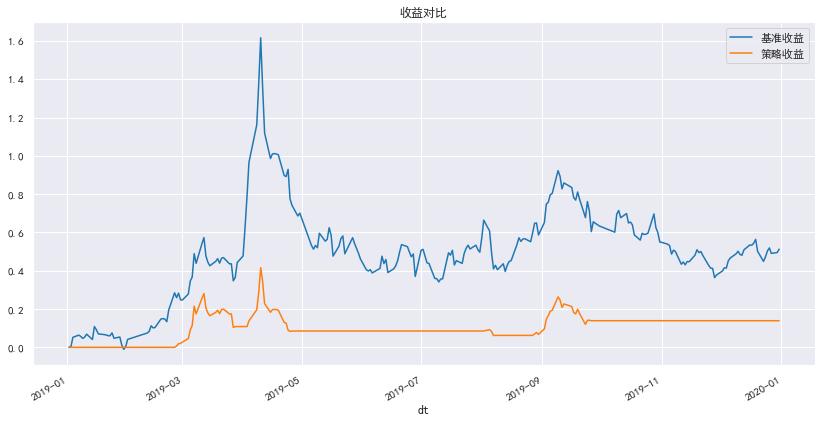

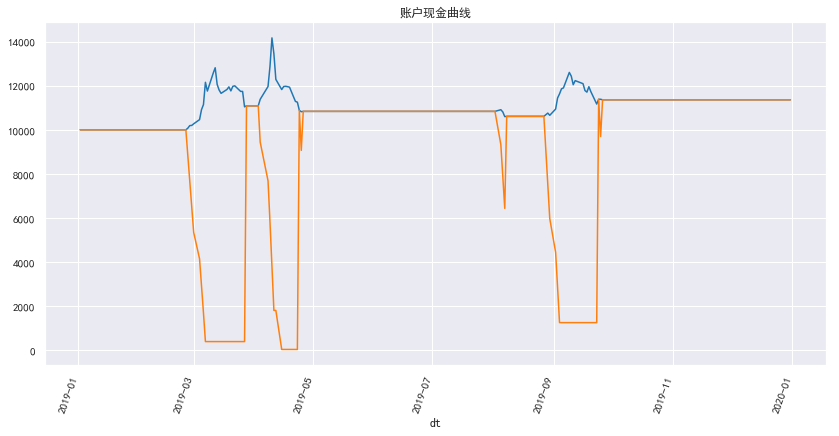

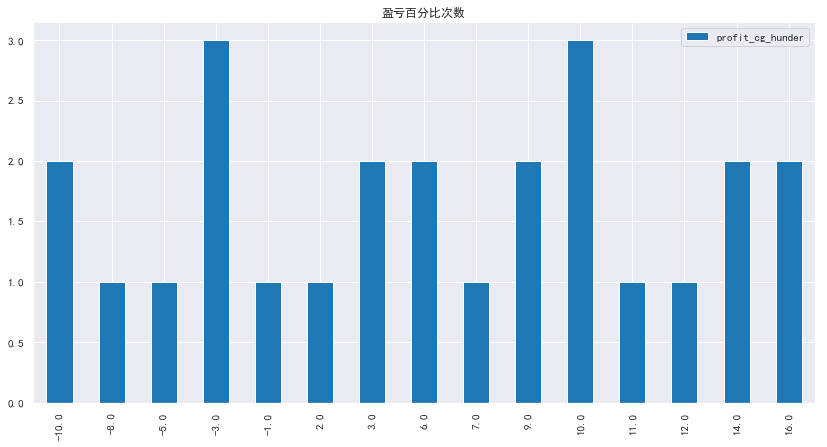

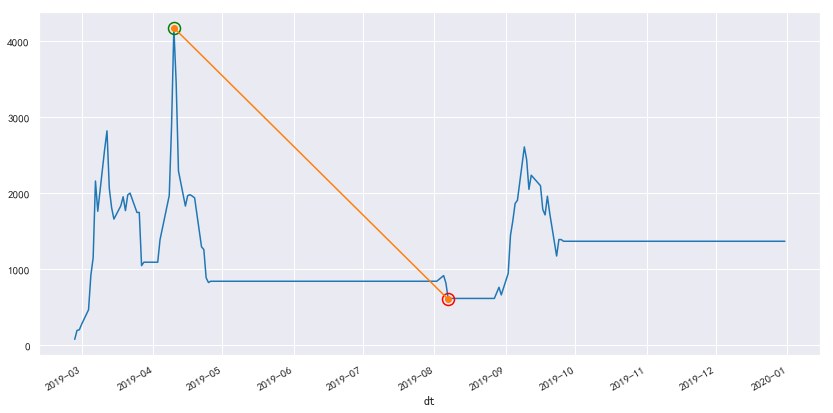

最大回撤: 0.251926
最大回测启始时间:2019-04-10, 结束时间2019-08-07, 共回测3569.505000
策略持股天数平均数: 12.842
策略持股天数中位数: 13.000


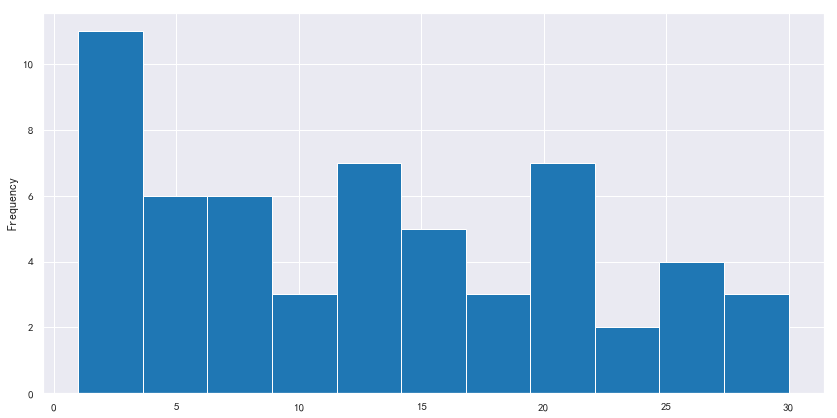

因子平均生效间隔:8.791666666666666


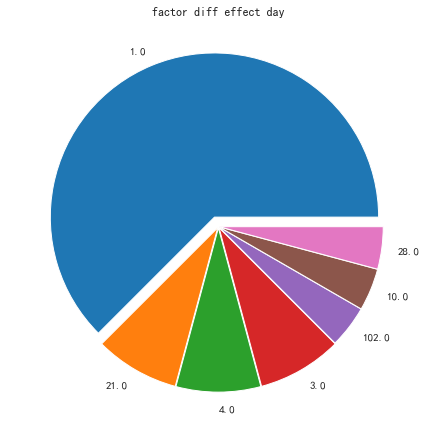

开仓花费情况: 
count:25
max:2009.9181680410425
min:1150.1861395112867
mean:1510.8078614654794
std:260.7285957831068
skewness:0.16814427572851218
kurtosis:-0.9521470706675124


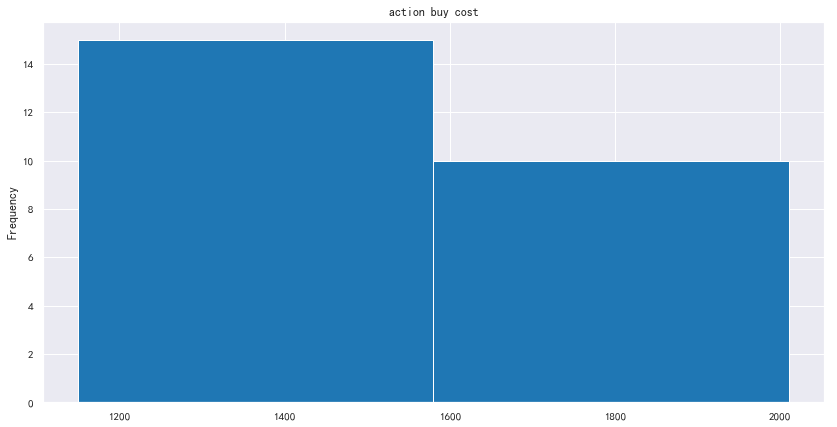

In [133]:
plot_cum_returns(bt_2019)
plot_capital_blance(bt_2019)
plot_win_loss_bar(bt_2019)
bt_2019.plot_max_draw_down()
bt_2019.plot_keep_days()
bt_2019.plot_effect_mean_day()
bt_2019.plot_action_buy_cost()

## 使用凯利公式对仓位进行管理

根据[回测-自制策略-布林带开口](#%E8%8E%B7%E5%88%A9%E6%9C%9F%E6%9C%9B)

- 胜率:58.62%
- 平均获利期望:18.77%
- 平均亏损期望:-3.91%

In [134]:
buy_factors = [
    {
        'class': BuyStrategy1,
        # 仓位管理
        'position': {'class': abupy.AbuKellyPosition, 'win_rate': bt1.win_rate, 
                                        'gains_mean': bt1.gains_mean, 'losses_mean': -bt1.losses_mean}
    }
]
# 卖出因子
sell_factors = [{
    'class': SellStrategy1,
},]
bt_2019_kelly = backtest(buy_factors, sell_factors,start='2019-01-01',end='2019-12-31')

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

### 结果

|                                                             |   盈亏总额 |   最终价值 |   交易次数 |   盈利次数 |   亏损次数 |   盈利比率 |   每笔交易平均盈亏额 |   盈利交易平均盈利额 |   亏损交易平均亏损额 |    R |   最大回撤 |   买入平均花费 |
|:------------------------------------------------------------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|---------------------:|---------------------:|---------------------:|-----:|-----------:|---------------:|
| 回测-自制策略-布林带开口                                    |   22159.5  |    27050.4 |        118 |         54 |         64 |   0.457627 |             144.448  |              410.361 |             -79.9153 | 1.81 |  -0.233849 |        2380.28 |
| 回测-自制策略-布林带开口-增加最多持仓天数的卖出策略         |   22159.5  |    27027.6 |        118 |         54 |         64 |   0.457627 |             141.088  |              410.361 |             -86.1102 | 1.64 |  -0.229233 |        2383.45 |
| 回测-自制策略-布林带开口-增加止损(1倍ATR）止盈（10倍ATR）   |   22159.5  |    27050.4 |        118 |         54 |         64 |   0.457627 |             144.448  |              410.361 |             -79.9153 | 1.81 |  -0.233849 |        2380.28 |
| 回测-自制策略-布林带开口-增加有持仓情况下2倍ATR时的加仓策略 |   26542.8  |    30941.9 |        137 |         65 |         72 |   0.474453 |             152.811  |              408.35  |             -77.8843 | 1.96 |  -0.229743 |        2314.4  |
| 回测-自制策略-布林带开口(2019年数据)                        |    2116.27 |    11362.9 |         25 |         17 |          8 |   0.68     |              54.4967 |              124.486 |             -94.231  | 0.58 |  -0.250545 |        1510.81 |
| 回测-自制策略-布林带开口+凯利公式仓位控制(2019年数据)       |    2718.83 |    11976.3 |         11 |          6 |          5 |   0.545455 |             179.602  |              453.138 |            -148.642  | 1.21 |  -0.321976 |        4084.19 |

In [138]:
print(gquant.pd.concat([bt1.profit_series(name='回测-自制策略-布林带开口'),
                  bt2.profit_series(name='回测-自制策略-布林带开口-增加最多持仓天数的卖出策略'),
                  bt3.profit_series(name='回测-自制策略-布林带开口-增加止损(1倍ATR）止盈（10倍ATR）'),
                  bt4.profit_series(name='回测-自制策略-布林带开口-增加有持仓情况下2倍ATR时的加仓策略'),
#                   bt5.profit_series(name='回测-通道策略-ATR波幅通道+最多持仓天数+2倍ATR加仓的策略'),
                  bt_2019.profit_series(name='回测-自制策略-布林带开口(2019年数据)'),
                  bt_2019_kelly.profit_series(name='回测-自制策略-布林带开口+凯利公式仓位控制(2019年数据)')], axis=1).T.to_markdown())

|                                                             |   盈亏总额 |   最终价值 |   交易次数 |   盈利次数 |   亏损次数 |   盈利比率 |   每笔交易平均盈亏额 |   盈利交易平均盈利额 |   亏损交易平均亏损额 |    R |   最大回撤 |   买入平均花费 |
|:------------------------------------------------------------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|---------------------:|---------------------:|---------------------:|-----:|-----------:|---------------:|
| 回测-自制策略-布林带开口                                    |   22159.5  |    27050.4 |        118 |         54 |         64 |   0.457627 |             144.448  |              410.361 |             -79.9153 | 1.81 |  -0.233849 |        2380.28 |
| 回测-自制策略-布林带开口-增加最多持仓天数的卖出策略         |   22159.5  |    27027.6 |        118 |         54 |         64 |   0.457627 |             141.088  |              410.361 |             -86.1102 | 1.64 |  -0.229233 |        2383.45 |
| 回测-自制策略-布林带开口-增加止损(1倍ATR）止盈（10倍ATR）   |   22159.5  |    27050.4 |        118 |         54 |         64

### 结果绘图

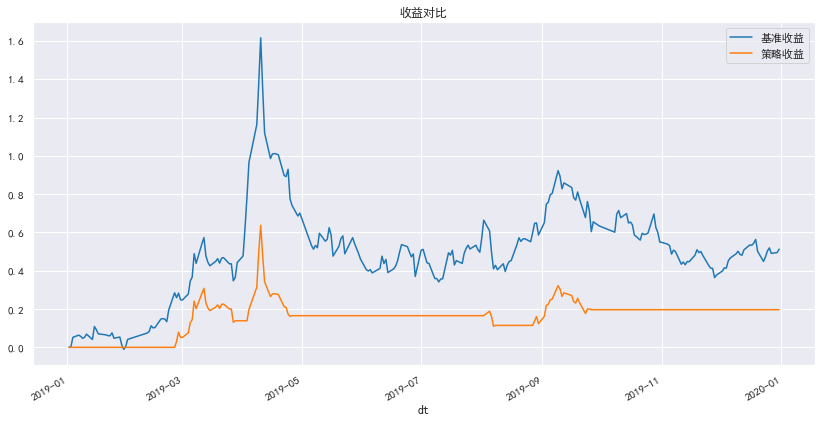

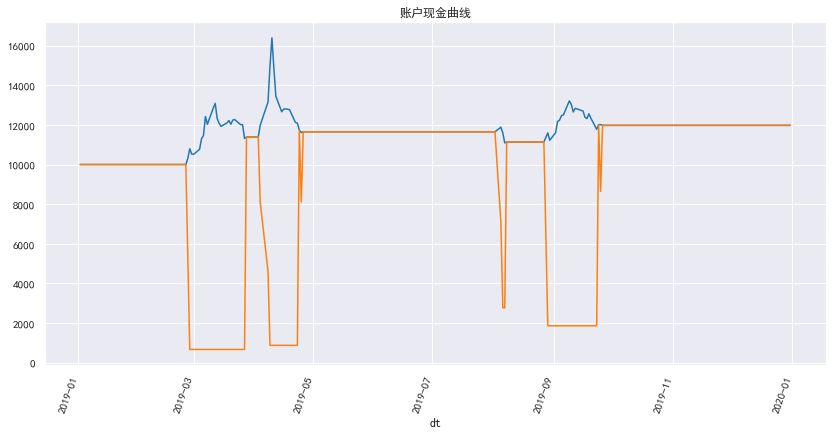

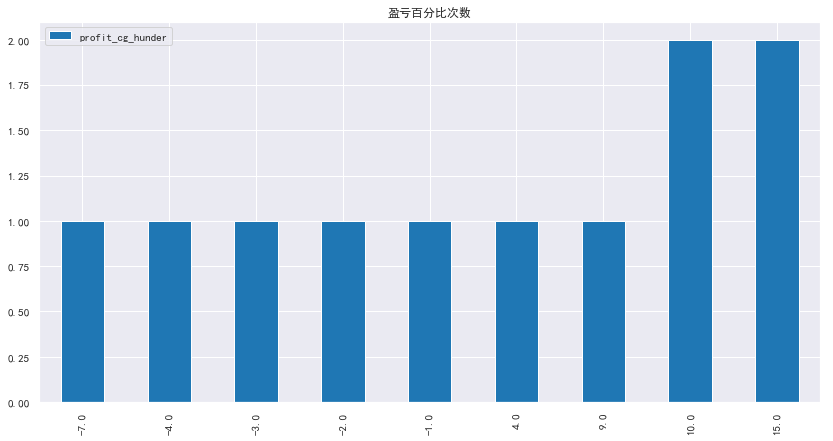

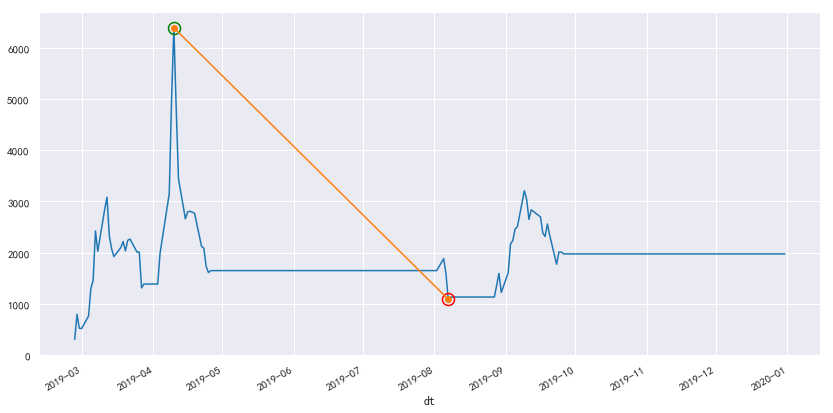

最大回撤: 0.323288
最大回测启始时间:2019-04-10, 结束时间2019-08-07, 共回测5298.762000
策略持股天数平均数: 12.842
策略持股天数中位数: 13.000


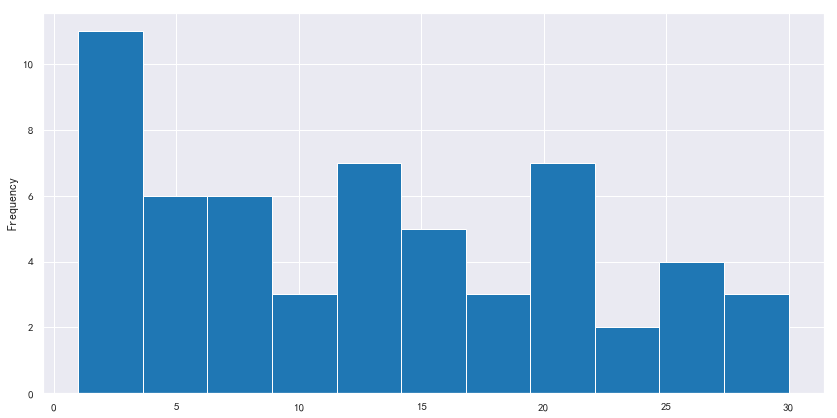

因子平均生效间隔:21.1


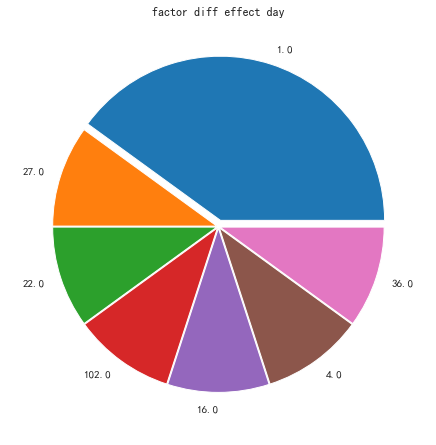

开仓花费情况: 
count:11
max:4665.732157878888
min:3281.949154188571
mean:4084.1930417571743
std:553.8413130324038
skewness:-0.23725877707317863
kurtosis:-1.7392786051865923


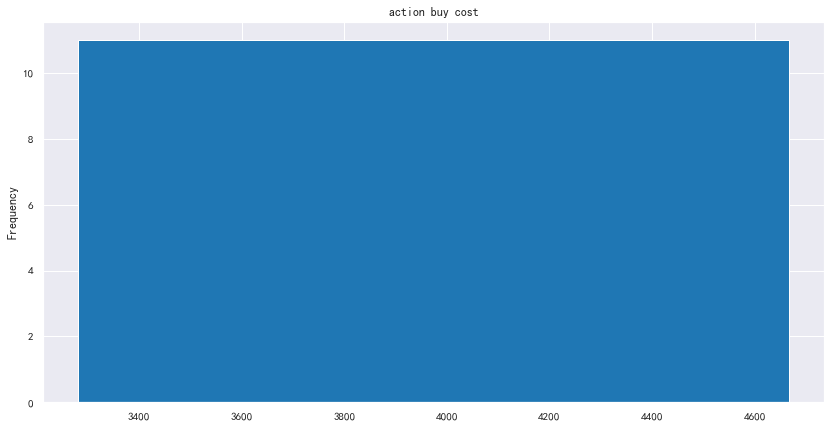

In [136]:
plot_cum_returns(bt_2019_kelly)
plot_capital_blance(bt_2019_kelly)
plot_win_loss_bar(bt_2019_kelly)
bt_2019_kelly.plot_max_draw_down()
bt_2019_kelly.plot_keep_days()
bt_2019_kelly.plot_effect_mean_day()
bt_2019_kelly.plot_action_buy_cost()

买入后卖出的交易数量:18
买入后尚未卖出的交易数量:2
胜率:61.1111%
平均获利期望:30.8059%
平均亏损期望:-6.1343%
盈亏比:5.2353
策略收益: 36.8669%
基准收益: 51.3113%
策略年化收益: 38.0756%
基准年化收益: 52.9937%
策略买入成交比例:75.0000%
策略资金利用率比例:19.5212%
策略共执行244个交易日


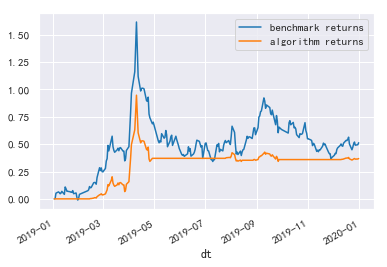

In [52]:
bt_2019.plot_returns_cmp(only_show_returns=True)

买入后卖出的交易数量:57
买入后尚未卖出的交易数量:0
胜率:57.8947%
平均获利期望:5.8001%
平均亏损期望:-2.4710%
盈亏比:3.4028
策略收益: 19.6605%
基准收益: 51.3113%
策略年化收益: 20.3051%
基准年化收益: 52.9937%
策略买入成交比例:19.2982%
策略资金利用率比例:20.0372%
策略共执行244个交易日


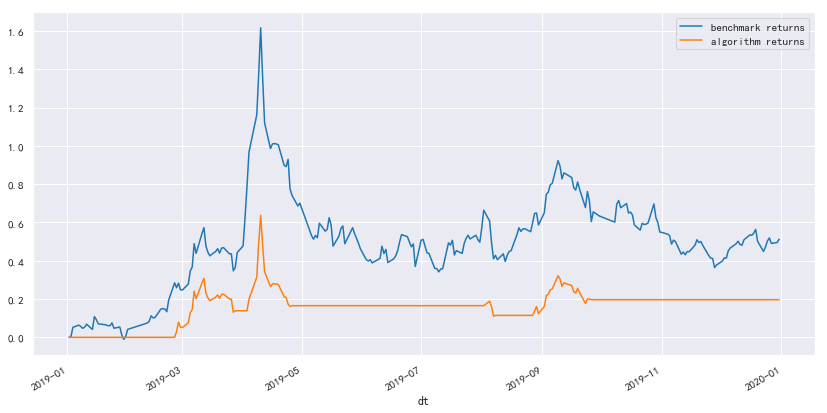

In [137]:
bt_2019_kelly.plot_returns_cmp(only_show_returns=True)

# 蒙特卡洛模拟

采用完整数据，从中随机选出500~1500天的连续数据，使用[Position1](#%E4%BB%93%E4%BD%8D%E6%8E%A7%E5%88%B6%E6%96%B9%E6%B3%95)（每次买入100股）的买卖策略进行测试。

In [140]:
import random
from QUANTAXIS.QAUtil.QADate import QA_util_datetime_to_strdate as dt2str
def generator():
    """随机选择迭代器"""
    while True:
        size=random.randint(500,1500)
        start=random.randint(0,len(ori_data_df_qfq)-size)
        end=start+size
        v= ori_data_df_qfq.iloc[start:end].reset_index()
        yield dt2str(v.iloc[0]['date'].date()),dt2str(v.iloc[-1]['date'].date())
g=generator()

In [141]:
buy_factors = [
    {
        'class': BuyStrategy1,
        # 仓位管理
        'position': {
            'class': Position1
        }
    },
]
# 卖出因子
sell_factors = [{
    'class': SellStrategy1,
},]
def do_mc_test(times):
    from tqdm import tqdm_notebook
    test=[]
    for i in tqdm_notebook(range(times)):
        s,e=next(g)
#         logging.info('LEN:{}:{}~{}'.format(len(test),s,e))
        mc=backtest(buy_factors, sell_factors,start=s,end=e)
        if mc:
            test.append(mc)
    result=gquant.pd.concat([m.profit_series() for m in test],axis=1).T
    return result
def show_result(times,mcs):
    gquant.sns.distplot(mcs[mcs['交易次数']>=30]['R'])
    logging.info("测试{}次后交易次数>30的R乘数：\n{}".format(times,mcs[mcs['交易次数']>=30]['R'].describe()))

## 100次

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=21328 begin work'), FloatProgress(value=0.0)))

测试100次后交易次数>30的R乘数：
count    88.0000
mean      1.5645
std       0.7051
min       0.1000
25%       0.9700
50%       1.7350
75%       2.0275
max       2.7200
Name: R, dtype: float64


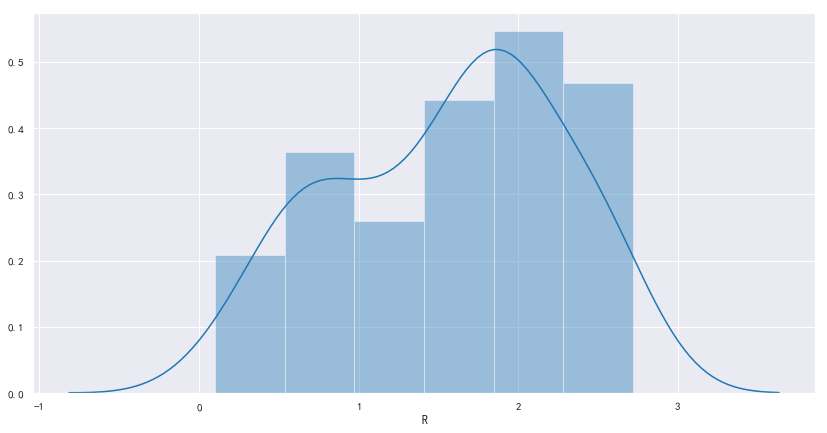

In [142]:
mcs100=do_mc_test(100)
show_result(100,mcs100)

## 1000次

In [ ]:
mcs1000=do_mc_test(1000)
show_result(1000,mcs1000)

## 10000次

In [ ]:
mcs10000=do_mc_test(10000)
show_result(10000,mcs10000)

In [153]:
mct=gquant.pd.DataFrame({
    100:mcs100[mcs100['交易次数']>=30]['R'].describe(),
    1000:mcs100[mcs1000['交易次数']>=30]['R'].describe(),
#     10000:mcs100[mcs10000['交易次数']>=30]['R'].describe(),
}).T
mct.index.name='测试轮数'
print(mct.to_markdown())

|   测试轮数 |   count |    mean |      std |   min |   25% |   50% |    75% |   max |
|-----------:|--------:|--------:|---------:|------:|------:|------:|-------:|------:|
|        100 |      88 | 1.56455 | 0.705114 |  0.1  |  0.97 | 1.735 | 2.0275 |  2.72 |
|       1000 |      89 | 1.43618 | 0.759784 |  0.09 |  0.69 | 1.56  | 1.97   |  2.72 |
